In [1]:
%load_ext autoreload
%autoreload 2

#### Модель детектирования схожих текстовых фрагментов в паре документов

Модель основана на представлении текста как генома:
- исследуемый геном - текст для проверки
  - предварительная обработка - секвенирование (фрагментация) исследуемого генома
- референсный геном - возможный текст-источник
  - выравнивание - поиск в референсном геноме фрагментов исследуемого генома
  
После выравнивания геномов выделяются признаки для кластеризации - пара координат фрагментов в каждом из документов. Пара признаков обеспечивают хорошую графическую визуализацию результатов.

Алгоритм кластеризации - *DBSCAN*, причины выбора:
- плоская структура (нет иерархии)
- кластеры обладают высокой плотностью в сравнении с шумом
- количество фрагментов априори неизвестно

Алгоритм хорошо работает со стандартной L2 метрикой. Эксперименты с кастомизацией метрики не показали повышения качества.

##### Получение исследуемого и референсного геномов

In [2]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt

In [3]:
PATH_PDF = '../test_data'

In [4]:
WORK_DIR_PATH = os.path.join(PATH_PDF, '1')
SAMPLE_DOC = '1.pdf'
REF_DOC = '2.pdf'

# WORK_DIR_PATH = os.path.join(PATH_PDF, '2')
# SAMPLE_DOC = '3.pdf'
# REF_DOC = '4.pdf'

# WORK_DIR_PATH = os.path.join(PATH_PDF, '3')
# SAMPLE_DOC = '5.pdf'
# REF_DOC = '6.pdf'

PNG_SAMPLE_PATH = os.path.join(WORK_DIR_PATH, 'png-sample')
PNG_REF_PATH    = os.path.join(WORK_DIR_PATH, 'png-ref')
TXT_SAMPLE_PATH = os.path.join(WORK_DIR_PATH, 'txt-sample')
TXT_REF_PATH    = os.path.join(WORK_DIR_PATH, 'txt-ref')

In [5]:
sample_skip_pages = [0,1] + list(range(139,148))
ref_skip_pages    = [0,1] + list(range(124,136))
sample_predef_real_page_nums = None
ref_predef_real_page_nums    = None

# sample_skip_pages = [0,1] + list(range(179,215))
# ref_skip_pages    = [0,1] + list(range(215,242))
# sample_predef_real_page_nums = None
# ref_predef_real_page_nums    = None

# sample_skip_pages = [0,1] + list(range(174,217))
# ref_skip_pages    = [0,1] + list(range(160,201))
# sample_predef_real_page_nums = list(range(1, 58)) + list(range(63, 94)) + list(range(97, 208)) + \
#         [208, 208, 209, 210, 211, 212, 213, 214, 215, 215, 216, 216, 217, 218, 218, 219, 220, 221]
# ref_predef_real_page_nums    = list(range(1, 45)) + list(range(51, 127)) + list(range(128, 209))

In [6]:
# wrapper API
from page_reader import PageReader

sample_reader = PageReader(TXT_SAMPLE_PATH, sample_skip_pages, predef_real_page_nums=sample_predef_real_page_nums)
result = sample_reader.read_pages(verbose=False)
sample_txt, sample_ls_positions, sample_real_page_nums, sample_line_ys = result

ref_reader = PageReader(TXT_REF_PATH, ref_skip_pages, predef_real_page_nums=ref_predef_real_page_nums)
result = ref_reader.read_pages(verbose=False)
ref_txt, ref_ls_positions, ref_real_page_nums, ref_line_ys = result

len(sample_txt), len(ref_txt)



WARN no lines found on page 135, skipping


(215322, 165412)

In [7]:
genome_ref = ref_txt
genome_sample = sample_txt

проверка парсинга страниц

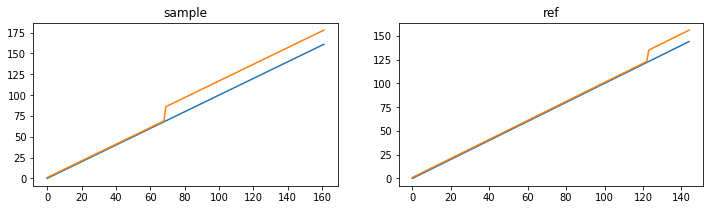

In [8]:
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.title('sample')
plt.plot(sample_real_page_nums.items())
plt.subplot(122)
plt.title('ref')
plt.plot(ref_real_page_nums.items())

##### Секвенирование (дробление) исследуемого генома

In [9]:
np.random.seed(42)

In [10]:
from bio_engine import sequencing, alignment

In [11]:
samples, sample_page_coords = sequencing(genome_sample, sample_ls_positions, 
                                         sample_size=(10, 10), sample_count=0.2, verbose=True)

SEQUENCING samples...
SEQUENCING: sample_size (10, 10), sample_count 0.2
SEQUENCING: samples generated total|unique|duplicated 39040|33244|5796
SEQUENCING: page_coords 39040


##### Выравнивание референсного генома

In [12]:
%%time
links, ref_page_coords = alignment(genome_ref, ref_ls_positions, samples, verbose=True)

ALIGNMENT samples...
ALIGNMENT: samples located total|unique|duplicated 228279|11478|216801
ALIGNMENT: ref_page_coords 42150
CPU times: user 11.3 s, sys: 18.8 ms, total: 11.4 s
Wall time: 11.4 s


##### Визуализация связей

In [13]:
print(f'Total positions found:   {len(links)}')
print(f'Unique sample positions: {len({x for x, _ in links})}')
print(f'Unique ref positions:    {len({x for _, x in links})}')

Total positions found:   228279
Unique sample positions: 16466
Unique ref positions:    42150


In [14]:
def graph_links(links, 
                genome_ref, genome_sample, 
                alpha=0.01):
    '''Graph with dict links
    Input:
      links:list(tuple(int*2)) - list of sample position, reference position
      genome_ref(str), genome_sample(str) - texts
      alpha(float) - opacity
    '''
    if not links:
        print('Empty links, exiting')
        return
    
    point_count = len(links)
    points_xs = list(zip(*links))
    sample_points_xs = points_xs[0]
    ref_point_xs = points_xs[1]

    # scatter
    plt.figure(figsize=(14, 14))
    plt.xlabel('Reference genome')
    plt.xticks(range(0, len(genome_ref), 10000), rotation='vertical')
    plt.ylabel('Sample genome')
    plt.yticks(range(0, len(genome_sample), 10000))
    plt.grid()
    plt.scatter(ref_point_xs, sample_points_xs, s=1, alpha=0.5)

    # 2 parallel lines links
    points_from = list(zip(ref_point_xs, [1] * point_count))
    points_to = list(zip(sample_points_xs, [0] * point_count))
    segs = zip(points_from, points_to)

    plt.figure(figsize=(16, 4))
    xlim = max(len(genome_ref), len(genome_sample))
    ax = plt.axes()
    plt.xticks(range(0, xlim, 10000), rotation='vertical')
    plt.yticks(range(2), ['sample', 'ref'])
    ax.set_xlim(0, xlim)
    ax.set_ylim(0, 1)

    from matplotlib.collections import LineCollection
    line_segments = LineCollection(segs, linewidths=(0.5), alpha=alpha,
                                   colors=('r', 'b', 'g', 'y', 'c', 'm'), 
                                   linestyle='solid')
    ax.add_collection(line_segments)  
    plt.show()

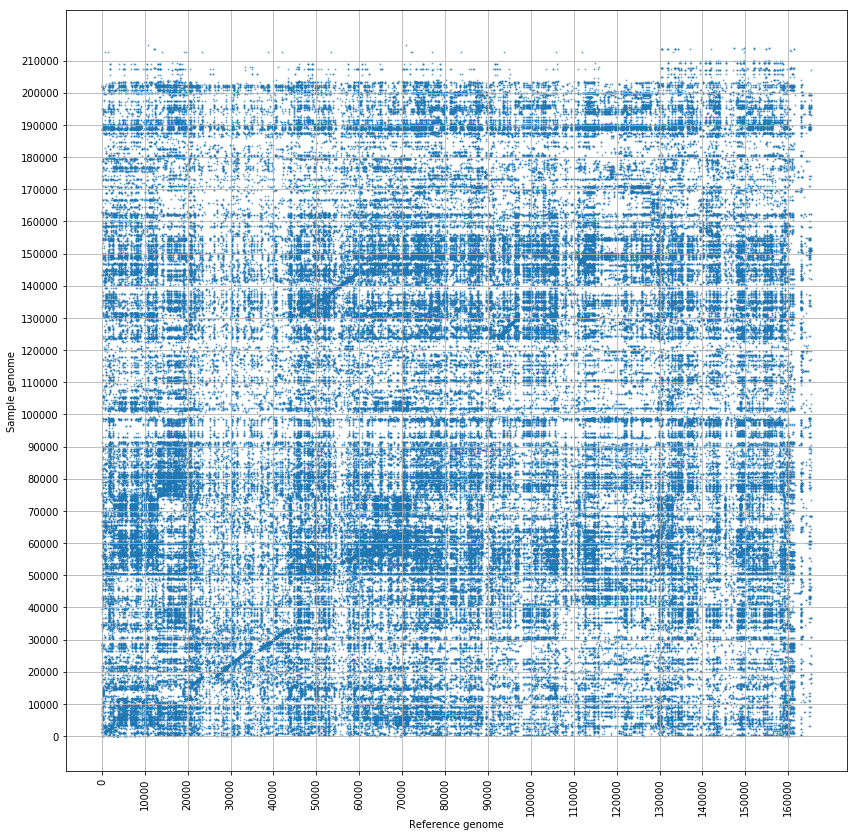

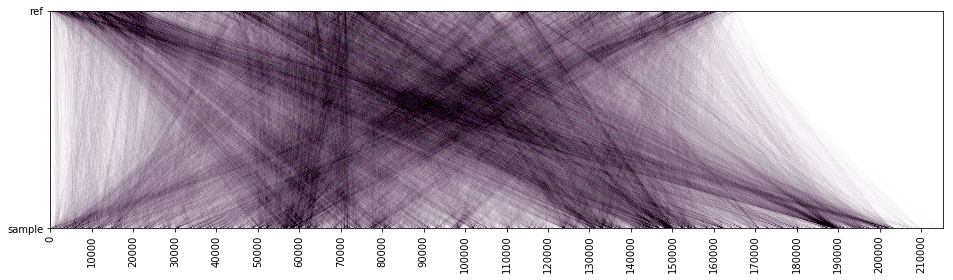

CPU times: user 17.9 s, sys: 156 ms, total: 18.1 s
Wall time: 18.1 s


In [15]:
%%time
graph_links(links, genome_ref, genome_sample, alpha=0.005)

##### Фильтрация шума

In [16]:
from filter_v4 import filter_noise

In [17]:
%%time
links_raw = links
links = filter_noise(links, eps=100, n_steps=5, verbose=True)

FILTERING positions step 1 of 5 ...
FILTERING before|after|filtered 228279|27411|200868
FILTERING positions step 2 of 5 ...
FILTERING before|after|filtered 27411|10267|17144
FILTERING early stop by reaching 25000
CPU times: user 1.6 s, sys: 7.96 ms, total: 1.61 s
Wall time: 1.61 s


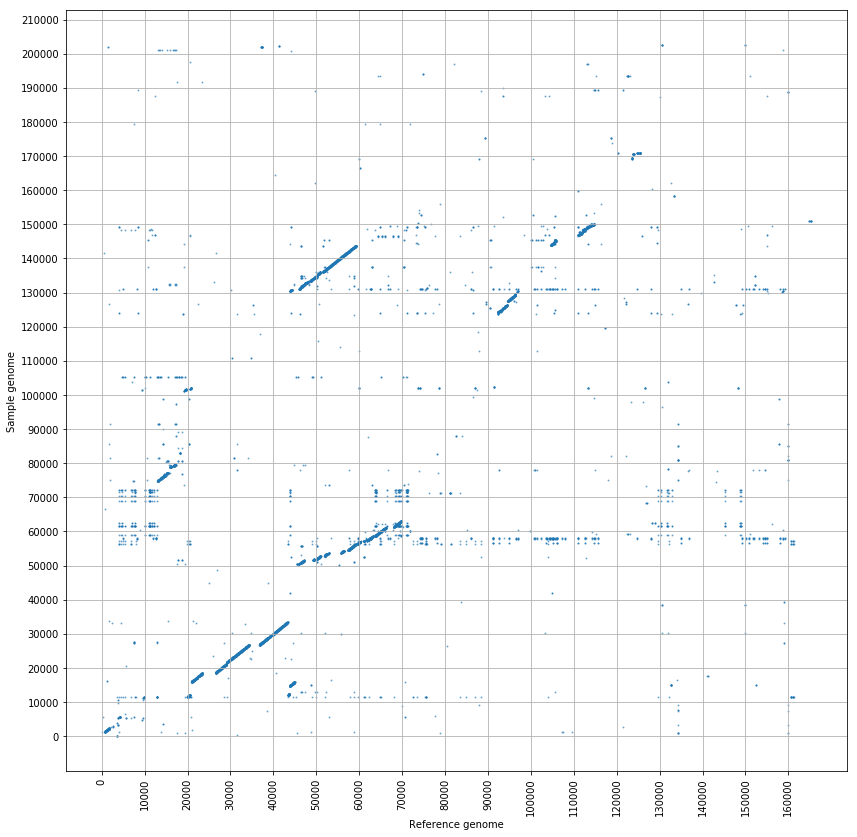

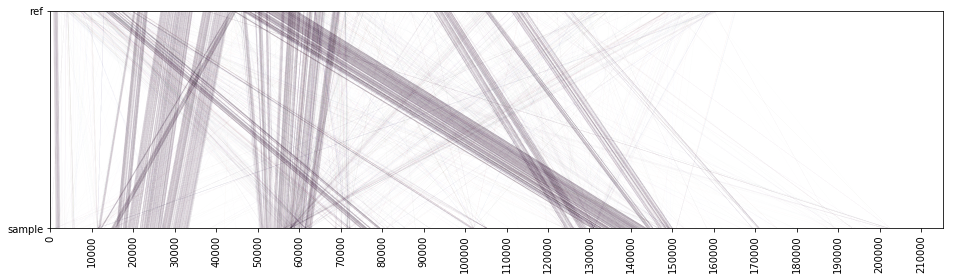

In [18]:
graph_links(links, genome_ref, genome_sample)

##### Кластеризация

In [19]:
from bio_engine import calculate_similar_areas

SIMILARITY: euclidean metric, eps=500, min_samples=60
SIMILARITY: clusters count: 28
COORDS: cluster #   0, sample [  1286 ..   2568], ref [   714 ..   2071]
COORDS: cluster #   1, sample [ 11434 ..  12061], ref [ 19966 ..  20549]
COORDS: cluster #   2, sample [ 14679 ..  15839], ref [ 43776 ..  44951]
COORDS: cluster #   3, sample [ 15882 ..  18467], ref [ 20892 ..  23460]
COORDS: cluster #   4, sample [ 18557 ..  21119], ref [ 26529 ..  29054]
COORDS: cluster #   5, sample [ 21563 ..  26719], ref [ 29114 ..  34333]
COORDS: cluster #   6, sample [ 26806 ..  29346], ref [ 36757 ..  39318]
COORDS: cluster #   7, sample [ 29415 ..  33397], ref [ 39381 ..  43327]
COORDS: cluster #   8, sample [ 50509 ..  51524], ref [ 46016 ..  47186]
COORDS: cluster #   9, sample [ 51928 ..  52800], ref [ 50125 ..  50993]
COORDS: cluster #  10, sample [ 52483 ..  53570], ref [ 51912 ..  52886]
COORDS: cluster #  11, sample [ 53662 ..  54380], ref [ 55701 ..  56455]
COORDS: cluster #  12, sample [ 54460 .

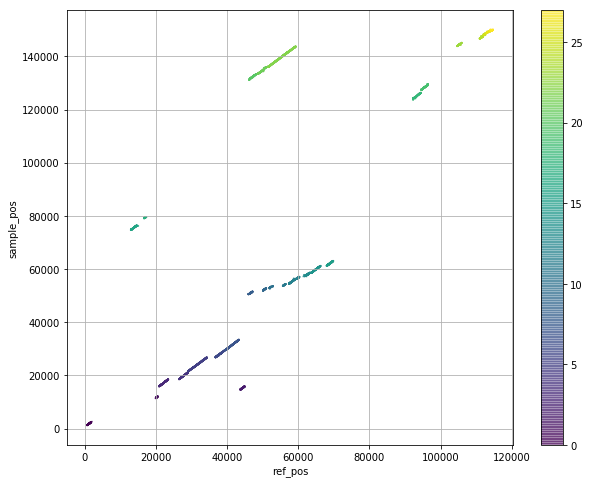

In [20]:
%%time
df_areas_pred = calculate_similar_areas(links, ref_page_coords, sample_page_coords,
                                        use_custom_metric=False,
                                        eps=500, min_samples=60,
                                        show=True, verbose=1)

In [21]:
df_areas_pred.head()

,ref_begin,ref_begin_page_coords,ref_end,ref_end_page_coords,sample_begin,sample_begin_page_coords,sample_end,sample_end_page_coords
0,714,"(2, 12)",2071,"(3, 6)",1286,"(2, 22)",2568,"(3, 14)"
1,19966,"(17, 24)",20549,"(18, 5)",11434,"(9, 2)",12061,"(9, 11)"
2,43776,"(31, 20)",44951,"(32, 10)",14679,"(10, 28)",15839,"(11, 16)"
3,20892,"(18, 11)",23460,"(19, 27)",15882,"(11, 18)",18467,"(13, 5)"
4,26529,"(21, 21)",29054,"(23, 2)",18557,"(13, 7)",21119,"(14, 19)"


##### Вычисление метрик качества

In [22]:
import pandas as pd

In [23]:
PATH_MARKS = '../dataset'
PATH_MARK_FILES = os.path.join(PATH_MARKS, 'files.csv')
PATH_MARK_AREAS = os.path.join(PATH_MARKS, 'areas.csv')

In [24]:
file_df = pd.read_csv(PATH_MARK_FILES)
area_df = pd.read_csv(PATH_MARK_AREAS)

In [25]:
ref_mark_id = file_df[file_df['filename'] == REF_DOC]['file_id'].iloc[0]
sample_mark_id = file_df[file_df['filename'] == SAMPLE_DOC]['file_id'].iloc[0]
ref_mark_id, sample_mark_id

(2, 1)

In [26]:
df_areas = area_df.query(f'file_id1 == {sample_mark_id} & file_id2 == {ref_mark_id}')
columns_to_drop = ['file_id1', 'file_id2']
area_real_coords = df_areas.drop(columns_to_drop, axis=1).dropna().values.astype('int32')
area_real_coords = [((e, f), (g, h), (a, b), (c, d)) 
                    for a, b, c, d, e, f, g, h 
                    in area_real_coords]
area_positions = [(
    ref_reader.convert_real_coords_to_position(a),
    ref_reader.convert_real_coords_to_position(b),
    sample_reader.convert_real_coords_to_position(c),
    sample_reader.convert_real_coords_to_position(d)
    ) for a, b, c, d in area_real_coords
]
area_positions[:5], area_real_coords[:5]

([(704, 1767, 1262, 2375),
  (20045, 20509, 11546, 12081),
  (43424, 43692, 12090, 12406),
  (43762, 44970, 14665, 15858),
  (20942, 21558, 15914, 16490)],
 [((3, 13), (4, 2), (3, 23), (4, 12)),
  ((18, 27), (19, 6), (10, 5), (10, 13)),
  ((32, 16), (32, 20), (10, 14), (10, 19)),
  ((32, 21), (33, 12), (11, 29), (12, 18)),
  ((19, 14), (19, 23), (12, 20), (12, 29))])

In [27]:
area_pred_page_coords = df_areas_pred[['ref_begin_page_coords',
                                       'ref_end_page_coords', 
                                       'sample_begin_page_coords', 
                                       'sample_end_page_coords']].apply(tuple, axis=1).values.tolist()
area_pred_positions = df_areas_pred[['ref_begin', 'ref_end', 
                                     'sample_begin', 'sample_end']].apply(tuple, axis=1).values.tolist()
area_pred_real_coords = [(
    ref_reader.convert_page_to_real_coords(a),
    ref_reader.convert_page_to_real_coords(b),
    sample_reader.convert_page_to_real_coords(c),
    sample_reader.convert_page_to_real_coords(d)
    ) for a, b, c, d in area_pred_page_coords
]
area_pred_positions[:5], area_pred_real_coords[:5]

([(714, 2071, 1286, 2568),
  (19966, 20549, 11434, 12061),
  (43776, 44951, 14679, 15839),
  (20892, 23460, 15882, 18467),
  (26529, 29054, 18557, 21119)],
 [((3, 13), (4, 7), (3, 23), (4, 15)),
  ((18, 25), (19, 6), (10, 3), (10, 12)),
  ((32, 21), (33, 11), (11, 29), (12, 17)),
  ((19, 12), (20, 28), (12, 19), (14, 6)),
  ((22, 22), (24, 3), (14, 8), (15, 20))])

Доступные метрики при наличии `ground truth` меток для классов:
  - RI (Rand index), ARI (adjusted  RI)
  - MI (mutual information), NMI (normalized MI), AMI (adjusted MI)
  - homogenity, completeness, V-measure
  - FMI (Fowlkes-Mallows index)
  
Расчет метрик производится следующим образом:
  - после кластеризации признаки - пары позиций (ref_pos, sample_pos) + метки кластеров
  - для каждой пары вычисляются истинные метки кластеров на основе `ground truth`
  - строятся метрики качества кластеризации

In [28]:
def fill_labels(df, positions):
    '''Fill dataframe labels based on positions
    Input:
      df:pd.DataFrame - dataframe with links in ['sample_pos', 'ref_pos'] columns
      positions:list(tuple(int*4)) - areas with positions: (ref_begin, ref_end, sample_begin, sample_end)
    '''
    df = df.copy()
    for idx, (a, b, c, d) in enumerate(positions):
        df.loc[df['ref_pos'].between(a, b) & df['sample_pos'].between(c, d), 'label'] = idx
    df['label'] = df['label'].fillna(-1).astype(int)
    return df

In [29]:
df_links_raw = pd.DataFrame.from_records(links_raw, columns = ['sample_pos', 'ref_pos'])
df_area_positions = fill_labels(df_links_raw, area_positions)
df_area_pred_positions = fill_labels(df_links_raw, area_pred_positions)

In [30]:
from sklearn.metrics import adjusted_rand_score, jaccard_similarity_score, adjusted_mutual_info_score
from sklearn.metrics import homogeneity_completeness_v_measure, fowlkes_mallows_score, silhouette_score
ars = adjusted_rand_score(df_area_positions['label'], df_area_pred_positions['label'])
jss = jaccard_similarity_score(df_area_positions['label'], df_area_pred_positions['label'])
amis = adjusted_mutual_info_score(df_area_positions['label'], df_area_pred_positions['label'])
hcvs = homogeneity_completeness_v_measure(df_area_positions['label'], df_area_pred_positions['label'])
# fms = fowlkes_mallows_score(df_area_positions['label'], df_area_pred_positions['label'])
# ss = silhouette_score(df_area_positions['label'], df_area_pred_positions['label'])
print(ars, jss, amis)
print(hcvs) #, fms, ss)

0.906818807402066 0.951887821481608 0.8179292917323046
(0.8834460837140454, 0.8187601510423962, 0.8498740448369021)


/home/aermakov/miniconda3/envs/p36_dis/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


##### Вывод PDF

In [31]:
from graph_engine import prepare_colorations, save_to_pdf

In [32]:
images = prepare_colorations(df_areas_pred, PNG_REF_PATH, PNG_SAMPLE_PATH, 
                             REF_DOC, SAMPLE_DOC, 
                             ref_line_ys, sample_line_ys, verbose=True)

link#000 - showing only first pages from different ref pages: (2, 3)
link#000 - showing only first pages from different sample pages: (2, 3)
link#000 - ref page coords: 2 (12, None) -> sample page coords: 2 (22, None)
Converting line_ys using k=0.42331812998859747 and b=0
Converting line_ys using k=0.6544733362714852 and b=0
Creating ref thumbnail with (w,h)=(1050,1485) from (2480,3508)
Creating sample thumbnail with (w,h)=(1050,1485) from (1601,2269)
link#001 - showing only first pages from different ref pages: (17, 18)
link#001 - ref page coords: 17 (24, None) -> sample page coords: 9 (2, 11)
Converting line_ys using k=0.42331812998859747 and b=0
Converting line_ys using k=0.7051282051282052 and b=0
Creating ref thumbnail with (w,h)=(1050,1485) from (2480,3508)
Creating sample thumbnail with (w,h)=(1050,1485) from (1487,2106)
link#002 - showing only first pages from different ref pages: (31, 32)
link#002 - showing only first pages from different sample pages: (10, 11)
link#002 - ref 

link#019 - showing only first pages from different ref pages: (68, 69)
link#019 - showing only first pages from different sample pages: (86, 88)
link#019 - ref page coords: 68 (1, None) -> sample page coords: 86 (23, None)
Converting line_ys using k=0.42331812998859747 and b=0
Converting line_ys using k=0.6544733362714852 and b=0
Creating ref thumbnail with (w,h)=(1050,1485) from (2480,3508)
Creating sample thumbnail with (w,h)=(1050,1485) from (1601,2269)
link#020 - showing only first pages from different ref pages: (33, 35)
link#020 - showing only first pages from different sample pages: (89, 90)
link#020 - ref page coords: 33 (13, None) -> sample page coords: 89 (10, None)
Converting line_ys using k=0.42331812998859747 and b=0
Converting line_ys using k=0.6295040271301399 and b=0
Creating ref thumbnail with (w,h)=(1050,1485) from (2480,3508)
Creating sample thumbnail with (w,h)=(1050,1485) from (1666,2359)
link#021 - showing only first pages from different ref pages: (36, 37)
link#0

In [33]:
save_to_pdf(images)